## Iphone or not Iphone detection
*Bezhenaer OLga*

### Data collection:
I honestly did not cope with the data collection, so my colleagues shared it with me. However, I carried out the primary cleaning of data from garbage (pictures downloaded from avito on the subject of "iPhone" that do not contain photos of iPhones)

### Preparation stage

In [1]:
#import of libraries 
from keras.preprocessing import image
from keras.applications import resnet50, inception_v3, vgg16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.optimizers import Adam
import numpy as np
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import tensorflow as tf
from tensorflow.contrib import lite
import os
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
#installing Resnet18
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-925gaong-build
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


### Model creation

#### Loading model 

In [3]:
#importing Resnet18
from classification_models.resnet import ResNet18

In [4]:
#Loading the model (RESNET18) with pre-trained weights

num_classes = 2 

base_model = ResNet18 
base_model = ResNet18(weights='imagenet',input_shape=(224,224,3), include_top=False) 

x = GlobalAveragePooling2D()(base_model.output) 
predictions = Dense(512, activation='relu')(x) 
predictions = Dense(num_classes, activation='softmax')(predictions) 
model = Model(inputs=[base_model.input], outputs=predictions) 

for layer in model.layers: 
    layer.trainable = True

Instructions for updating:
Colocations handled automatically by placer.


#### Image transformation & data loaders

In [5]:
#Creating rule for images random transformation  (ramdom transformation)
train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

val_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(
        rescale=1./255,
        fill_mode='nearest')

In [6]:
#chosing batch size - parameter for modael tunning 
batch_size=64

In [7]:
#Setting the path to images (creating data loaders)
train_generator = train_datagen.flow_from_directory(
        'full dataset/train',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')
val_generator = val_datagen.flow_from_directory(
        'full dataset/val',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='binary')
test_generator = test_datagen.flow_from_directory(
        'full dataset/test',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
#          batch_size=batch_size,
        class_mode='binary')

Found 48902 images belonging to 2 classes.
Found 2035 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [8]:
#positive - Iphones, negative - Not iphones 
train_generator.class_indices

{'AOther': 0, 'Iphones': 1}

In [9]:
#Define sample sizes for further calculations 
nb_samples_train = len(train_generator.filenames)
nb_samples_val= len(val_generator.filenames)
nb_samples_test = len(test_generator.filenames)

#### Final step of the model building 

In [10]:
# Final step of model building (main hyperparameter for tunning)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['acc']) # 



In [12]:
#loading weights (was used to save the results of previous model training)
model.load_weights('model.hdf5')

In [13]:
# Train the model 
model.fit_generator(
        train_generator,
        steps_per_epoch=nb_samples_train/batch_size,
        epochs=200,
        validation_data=val_generator,
        validation_steps=nb_samples_val/batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
765/764 [==============================] - 688s 900ms/step - loss: 0.0410 - acc: 0.9845 - val_loss: 0.2530 - val_acc: 0.9283


In [14]:
model.save_weights("model.hdf5")

In [15]:
model.save('model.hdf5') 

### Reduction of the file size (compressing the model)

I use Tensorflow Lite, as the way to solve problem with loading large files in GitHub.

In [17]:
# Converting keras model to tflite model
converter = lite.TFLiteConverter.from_keras_model_file('model.hdf5')
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 100 variables.
INFO:tensorflow:Converted 100 variables to const ops.


45785876

The model "size" now is about 45MB.

### Measurement of the model quality

In [28]:
# function for loading and rescaling images
def load_image(img_path):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255.
    
    return img_tensor

In [32]:
val_dir='full dataset/val'

In [33]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="converted_model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

#walking through our validation set and get predictions for each photo
compr_pred = []
for subdir, dirs, files in os.walk(val_dir):
    for file in files:
        input_data = load_image(os.path.join(subdir, file))
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        compr_pred.append(output_data[0])

In [36]:
#result's check 
average_precision_compr = average_precision_score(val_generator.classes, [x[1] for x in compr_pred])
print('Average precision-recall score for compressed model: {0:0.10f}'.format(average_precision_compr))

Average precision-recall score for compressed model: 0.9850241076


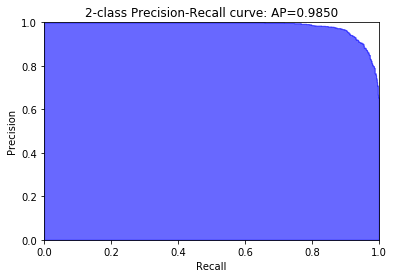

In [42]:
# plot the precision-recall curve
precision, recall, _ = precision_recall_curve(val_generator.classes, [x[1] for x in compr_pred])
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.4f}'.format(average_precision_compr))
plt.show()

In [43]:
! conda list -e > requirements.txt